<a href="https://colab.research.google.com/github/s1c5000/Books/blob/main/handson/cnn_%EC%A0%95%EB%A6%AC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

컨볼루션의 구조와 주요논문들을 설명한다.  
분류, 위치추정방법 모두 흐름을 바탕으로 이해하는 것이 좋다  
들어가는 이미지의 형태와 변화되는 모습도 확인해보며 그려볼수 있어야한다.  

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(42)


In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

(2, 427, 640, 3)
(7, 7, 3, 2)


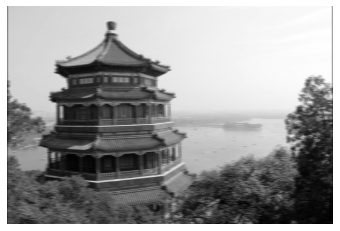

In [ ]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape
print(images.shape) # (2, 427, 640, 3)

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) # 7*7  3채널 필터 2개
filters[:, 3, :, 0] = 1  # vertical line  열부분 중간을 1로
filters[3, :, :, 1] = 1  # horizontal line  행부분 중간을 1로
print(filters.shape) # (7, 7, 3, 2)  # 7*7  3채널 필터 2개

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # 수평필터를 적용
plt.axis("off") # Not shown in the book
plt.show()

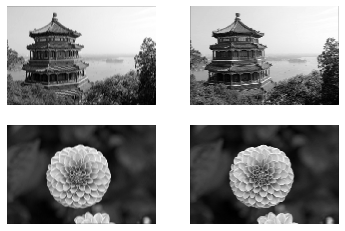

In [ ]:
for image_index in (0, 1):# 각각 수직 수평 필터 적용
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show() # 각각 필터를 거쳐나온 특성맵 들이다. 필터하나당 특성맵 하나생성

(7, 7, 3)


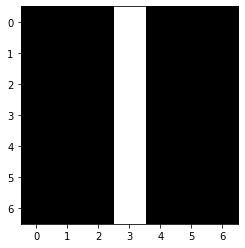

In [ ]:
# print(filters[:,:,:,0]) print로 출력해서 나오는 모양은 7*3행렬이 7개 나온다.
print(filters[:,:,:,0].shape) # 7*7*3
plt.imshow(filters[:,:,:,0], cmap="gray") # image로 출력하면 (행,열,채널) 로 인식

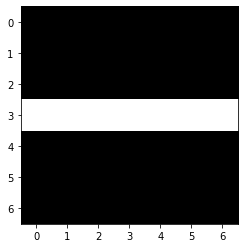

In [ ]:
plt.imshow(filters[:,:,:,1], cmap="gray")

In [ ]:
def crop(images): # 필터 효과 잘 보기위해 자른다.
    return images[150:220, 130:250]

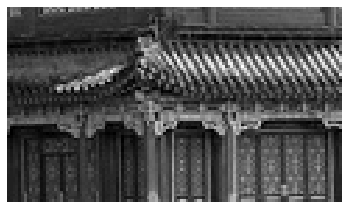

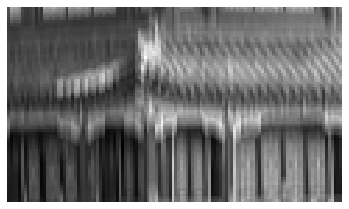

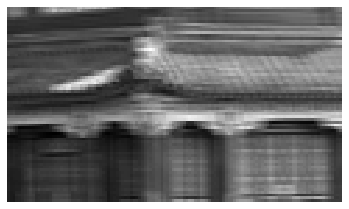

In [ ]:
plot_image(crop(images[0, :, :, 0]))
#save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    #save_fig(filename, tight_layout=False)
    plt.show() # 각각 특성맵이다.

보통 필터를 직접 만들기보다 keras.layers.Conv2D를 사용한다.


## conv 층

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

padding='valid' 패딩없음(크기 줄어듬)  
padding='same' 패딩 알아서 생김  
strides = 얼만큼 뛸지지

cnn은 메모리를 많이 잡아먹는다  
오차역전파를위해 정방향에서 계산됬던 모든 값이 보존되어야한다.  
각층에서 필요한 RAM양의 전체 합 만큼은 필요하다

## 풀링 층

이미지의 축소판을 만든다.

## CNN


합성곱층에 너무 큰 커널(필터)를 사용하면 안된다. 5* 5 합성곱 층보다 3* 3 커널2개를 쌓는것이 계산량이 적고 성능도 좋다  
예외적으로 입력층은 큰 커널을 사용한다. 너무 많은 정보를 잃지않기 위해서이다.

In [ ]:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]
print(X_train.shape)

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
print(X_train.shape)

X_train = X_train[..., np.newaxis] # 차원 추가_test = (X_test - X_mean) / X_std
print(X_train.shape)

X_train = X_train[..., np.newaxis] # 차원 추가
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(X_train.shape)
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(X_train.shape)

4423680/4422102 [==============================] - 0s 0us/step
(55000, 28, 28)
(55000, 28, 28)
(55000, 28, 28, 1)
(55000, 28, 28, 1, 1)
(55000, 28, 28, 1, 1)


파라미터의 수와 출력의 모양을 계산해보는것이 흐름을 이해햐는데 도움이 된다

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), # 7*7 크기의 필터 사용, 7*7*1(필터깊이)*64+64 = 3200(파라미터 수)
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128), # 3*3 * 64(필터깊이) * 128 + 128 = 73856
    DefaultConv2D(filters=128), # 3*3 * 128 * 128 + 128 = 147584
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256), # CNN에선 필터수를 차차늘리는게 일반적, 적은수의 저수준 특성을 많은 고수준 특성과 연결, 3*3 * 128 * 256 + 256 = 295168
    DefaultConv2D(filters=256), # 풀링층에서 공간차원을 절반으로 줄이므로 필터수를 2배로 늘리는게 일반적
    keras.layers.MaxPooling2D(pool_size=2), # 파라미터개수, 메모리, 계산비용을 크게 늘리지않고 특성맵 개수를 두배로 늘릴 수 있다.
    keras.layers.Flatten(), # 쫙 펴버린다, 3 * 3 * 256 ( 특성맵 가로 * 세로 * 깊이)= 2304(아웃풋)
    keras.layers.Dense(units=128, activation='relu'), # 2304 * 128 + 128 = 295040
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'), # 128 * 64 + 64 = 8256
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'), # 64 * 10 + 10 = 650
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         5

In [ ]:
# model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
# score = model.evaluate(X_test, y_test)
# X_new = X_test[:10] # pretend we have new images
# y_pred = model.predict(X_new)

## 주요 CNN모델들의 비교

### LeNet-5

보통 처음 CNN을 처음 배울때 사용되는 구조와 비슷  
mnist인식에 널리사용  

입력 -> 합성곱 -> 평균풀링 -> 합성곱 -> 평균풀링 -> 합성곱 -> 완전연결 -> 출력  

### AlexNet
top-5에러율이 17%로 이미지넷(2012)에서 우승  
처음으로 합성곱 층 위에 풀링층을 쌓지 않았다.  

입력 -> 합성곱 -> 최대풀링 -> 합성곱 -> 최대풀링 -> 합성곱 -> 합성곱 -> 합성곱 -> 최대풀링 -> 완전연결 -> 완전연결 -> 출력  

과대적합을 막기위해 
완전연결층 사이를 드롭아웃 50프로 주었다
데이터 증식 사용  
처음 두번의 합성곱 층에서 LRN 층을 사용  
LRN : 가장 강하게 활성화된 뉴런이 다른 특성 맵에 있는 같은 위치의 뉴련을 억제 -> 더 다양한 특징을 탐색하도록 만든다(실제 생물학적 뉴련에서도 관측됨)  

AlexNet의 변종으로 2013년 우승

### GoogLeNet
2014년도 이미지넷에서 우승, top-5 에러율 7%로 줄임  
기존 CNN보다 매우 깊음  
인셉션모듈이라는 서브 네트워크를 가지고 있다  
파라미터를 매우 효과적으로 사용한다 ( AlexNet보다 10배나 적은 파라미터사용(600만개)  

인셉션모듈  
입력이 복사되어 네개의 다른 층에 주입  
각각 다른 크기의 커널크기를 사용하여 여러 특성을 찾는다

9개의 인셉션모듈이 사용되었다  
인셉션 모듈로 들어가기 전 두번의 최대풀링으로 공간크기를 줄여놓았다. -> 계산속도 높임  


### VGGNet
같은 2014년도 2등을 함  
매우 단순  
2개나 3개의 합성곱 층 뒤에 풀링 층이 나온다 위 구조를 반복  
3*3 필터만 사용한다

### ResNet
이미지넷 2015 승리, top-5에러율 3.6%  
152개의 층으로 구성된 CNN사용  
더 적은 파라미터로 더 깊은 네트워크를 만드는 트렌드를 만듬  
깊은 네트워크를 훈련시킬 수 있는 핵심요소는 ***스킵연결(숏컷연결)*** 때문이다  
https://ganghee-lee.tistory.com/41  

기존의 신경망은 입력값 x를 타겟값 y로 매핑하는 함수 H(x)를 얻는 것이 목적이었다.  
그러나 ResNet은 H(x) = F(x) + x를 최소화하는 것을 목적으로 한다.  
( F(x)는 잔차유닛 사이층의 목적함수)  
F(x) = H(x) - x 이므로 F(x)를 최소로 해준다는 것은 H(x) - x를 최소로 해주는 것과 동일한 의미를 지닌다.  
 
즉, 잔차를 최소로 해주는 것이므로 ResNet이란 이름이 붙게 된다. 


미분을 해도 x자체는 미분값 1을 갖기 때문에  
각 layer마다 최소 gradient로 1은 갖도록 한 것이다 -> 그레이디언트 소실완화

### SENet
이미지넷 2017 우승, top-5 에러율 2.25%  
인셉션 네트워크와 ResNet 같은 기존구조를 확장   
인셉션 네트워크와 ResNet을 확장한 버전을 각각 SE-Inception과 SE-ResNet이라고 부른다.   
SE블록 이라는 작은 신경망을 추가항 성능 향상  


## ResNet-34구현

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs): # **kwargs : 인자가 dict형태로 입력
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation) # keras.activation.get()으로 relu가져옴
        self.main_layers = [
            DefaultConv2D(filters, strides=strides), # 잔차유닛의 첫번째층은 stride가 2가 될수 도 있기때문에 인자로 지정
            keras.layers.BatchNormalization(), # 배치정규화
            self.activation, # 활성화함수 relu
            DefaultConv2D(filters), # 잔차유닛의 2번째 층
            keras.layers.BatchNormalization()] # 배치 정규화
        self.skip_layers = [] # 스킵연결(숏컷연결)
        if strides > 1: # 잔차유닛마다 공간이 절반이되고 특성맵수는 두배로 늘어서 입력과 출력이 다르게된다.
                        # 이를 맞추기위해 스트라이드 2 이고 출력 특성맵의 수가 같은 1*1 합성곱 층으로 입력을 통과시킴
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs): # 객체 호출시 실행
        Z = inputs # super()로 kwargs들 초기화했으므로 keras.layers.Layer의 input이 된다.
        for layer in self.main_layers: # main_layers의 각 층
            Z = layer(Z) # 층으로 부터 받은 입력, f(x)
        skip_Z = inputs # 각 층으로 들어오는 입력, x
        for layer in self.skip_layers: # 입력과 출력의 크기가 달라서 stride = 2 일때만 skip_Z층을 바꾼다.
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z) # relu(x + f(x))

In [ ]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[224,224,3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides =2, padding = 'SAME'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  strides = 1 if filters == prev_filters else 2 # 출력과 입력의 크기를 맞춰주기위해 
  model.add(ResidualUnit(filters, strides = strides))
  prev_filters = filters # 입력과 출력의 크기가 다를때만 stride를 2로 하기위해 prev_filters update
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation = 'softmax'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_72 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 56, 56, 64)       

## 케라스에서 제공하는 사전훈련된 모델 사용

In [ ]:
[i for i in dir(keras.applications)] # 사용할 수 있는 사전훈련된 가중치, 뒤져보면 재미있는거 많음

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [ ]:
model = keras.applications.resnet50.ResNet50(weights = 'imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
model.layers

ResNet-50의 가중치를 다운받았다.

In [ ]:
model.layers[0].input # ResNet-50 은 224*224*3 이미지를 인풋으로 받는다.

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
# 사전 훈련된 모델은 이미지가 적절한 방식으로 전처리 되었다고 가정한다.
# 0에서 1사이 -1에서 1 사이 등 모델마다 기대하는 입력이 다르다
# preprocess_input()을 사용하면 모델마다 적절한 이미지 전처리를 해준다
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
# 위에서 255를 나눠줘서 픽셀이 0에서 1 사이의 값이다. 따라서 255를 곱해 0 에서 255사이의 값으로 변형

## 사전훈련된 모델 전이학습

In [ ]:
import tensorflow_datasets as tfds # tensorflow_datasets 임포트

#with_info=True로 저장하면 데이터셋의 정보 얻을 수 있다.
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True) 

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info # train세트만 있다.

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [ ]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [ ]:
n_classes = info.features["label"].num_classes

In [ ]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [ ]:
# train만 있으므로 나눠야한다.
# test를 처음 10프로, valid를 그 다음 15%, train을 뒤의 75%로 나눔
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [ ]:
# 인풋형식에 맞춰 preprocess한다.
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224]) # xception의 인풋크기에 맞춰 resize
    final_image = keras.applications.xception.preprocess_input(resized_image) # xception의 입력 픽셀에 맞춰 preprocess_input
    return final_image, label

In [ ]:
# train, test, valid 각각 preprocess 적용하고 배치크기를 지정한다.
# 속도 향샹을 위해 prefetch도 해준다.
from functools import partial
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat() # 훈련셋 셔플
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1) # 배치 크기를 지정하고 prefetch적용한다
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1) # prefetch는 s가 훈련중일때 s+1을 가져와서
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1) # 훈련 속도를 높인다.

In [ ]:
type(train_set)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
 # batch를 지정해서 한번에 32 개를 리턴한다.
 # take(n)으로 원하는 배치만큼 가져올 수 있다.
 # repeat(n) 으로 반복횟수 설정

 # batch와 repeat 둘다 순서는 랜험하게 반환
for i , sets in enumerate(train_set):
  x, y  = sets[0], sets[1]
  print(y)
  if i == 4:
    break

print()
for a, b in train_set.take(2).repeat(2):
  print(b)

tf.Tensor([4 0 3 3 2 2 1 1 0 4 2 2 4 1 2 0 0 0 0 1 0 3 0 4 3 4 4 0 4 0 2 4], shape=(32,), dtype=int64)
tf.Tensor([1 2 0 3 1 1 4 0 1 2 2 3 4 0 1 2 2 2 2 4 0 1 4 4 1 2 0 3 4 0 0 0], shape=(32,), dtype=int64)
tf.Tensor([3 1 1 0 1 0 0 4 2 2 0 0 2 4 3 3 0 4 3 3 0 1 0 0 3 3 2 4 2 3 0 1], shape=(32,), dtype=int64)
tf.Tensor([0 3 1 2 1 0 3 3 2 0 2 2 4 2 2 2 4 0 4 2 3 0 4 3 4 0 1 0 4 3 1 4], shape=(32,), dtype=int64)
tf.Tensor([3 4 3 4 4 2 1 0 0 3 2 2 2 0 2 3 2 2 4 2 4 3 3 1 0 2 3 3 0 3 3 3], shape=(32,), dtype=int64)

tf.Tensor([2 2 3 1 1 2 4 3 1 2 3 4 2 0 2 4 3 1 0 4 2 2 2 3 4 1 3 3 3 2 0 2], shape=(32,), dtype=int64)
tf.Tensor([2 2 0 4 3 3 4 4 4 1 3 1 2 3 1 3 2 1 3 4 1 4 0 1 0 1 4 0 4 4 3 4], shape=(32,), dtype=int64)
tf.Tensor([0 1 3 2 1 1 0 0 0 4 2 0 4 0 1 4 1 1 1 0 0 4 4 3 0 2 3 3 3 4 1 4], shape=(32,), dtype=int64)
tf.Tensor([1 2 3 0 0 4 3 0 0 0 0 2 2 4 3 1 2 0 4 2 3 0 4 1 0 0 0 1 0 2 0 0], shape=(32,), dtype=int64)


In [ ]:
# 모델 임포트
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
# base_model 층
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
# 전이학습으로 만든 층 , base_model과의 차이점은 마지막에 평균풀링과 출력층이 추가되었다.
for index, layer in enumerate(model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [ ]:
#base_model의 가중치를 동결
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# gpu로 바꾸고 실행
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 13s 102ms/step - loss: 2.5368 - accuracy: 0.6648 - val_loss: 1.4973 - val_accuracy: 0.8309
Epoch 2/5
86/86 [==============================] - 8s 91ms/step - loss: 0.7030 - accuracy: 0.9016 - val_loss: 1.0429 - val_accuracy: 0.8732
Epoch 3/5
86/86 [==============================] - 8s 90ms/step - loss: 0.2756 - accuracy: 0.9414 - val_loss: 0.9774 - val_accuracy: 0.8566
Epoch 4/5
86/86 [==============================] - 8s 91ms/step - loss: 0.1700 - accuracy: 0.9578 - val_loss: 0.8394 - val_accuracy: 0.8768
Epoch 5/5
86/86 [==============================] - 8s 91ms/step - loss: 0.0943 - accuracy: 0.9713 - val_loss: 0.8729 - val_accuracy: 0.8658


In [ ]:
# 이제 동결을 해제하고 학습.
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10) # 더 학습해도 되지만 10번만하겠다

Epoch 1/10
86/86 [==============================] - 38s 400ms/step - loss: 0.1814 - accuracy: 0.9473 - val_loss: 0.7778 - val_accuracy: 0.8511
Epoch 2/10
86/86 [==============================] - 33s 389ms/step - loss: 0.0636 - accuracy: 0.9834 - val_loss: 0.3377 - val_accuracy: 0.9154
Epoch 3/10
86/86 [==============================] - 33s 388ms/step - loss: 0.0261 - accuracy: 0.9903 - val_loss: 0.2890 - val_accuracy: 0.9191
Epoch 4/10
86/86 [==============================] - 33s 389ms/step - loss: 0.0159 - accuracy: 0.9962 - val_loss: 0.2948 - val_accuracy: 0.9210
Epoch 5/10
86/86 [==============================] - 33s 389ms/step - loss: 0.0188 - accuracy: 0.9933 - val_loss: 0.2890 - val_accuracy: 0.9191
Epoch 6/10
86/86 [==============================] - 33s 389ms/step - loss: 0.0103 - accuracy: 0.9988 - val_loss: 0.2603 - val_accuracy: 0.9246
Epoch 7/10
86/86 [==============================] - 33s 389ms/step - loss: 0.0031 - accuracy: 0.9997 - val_loss: 0.2702 - val_accuracy: 0.9301

## 분류와 위치 추정

바운딩박스를 예측하는 일반적인 방법은 물체 중심의 수평, 수직 좌표의 높이, 너비를 예측하는 것이다.  
네 개의 숫자를 예측해야한다.  
네 개의 유닛을 가진 두번째 밀집출력층을 추가하고 MSE 손실을 사용해 훈련한다  

In [ ]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output) # 평균풀링
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg) # 클래스 예측
loc_output = keras.layers.Dense(4)(avg) # 디텍션박스 예측
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output]) # 출력을 2개로

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

MSE는 모델을 훈련하기 위한 손실함수로 사용할 수 있지만   모델이 바운딩 박스를 얼마나 잘 예측하는지 평가하는 데는 좋은 지표가 아니다  
IoU(interaction over union)를 사용한다  
IoU는 중첩되는 영역을 예측과 레이블의 합집합으로 나눈다.  


## 객체탐지
꽤 오래 사용되던 방법은 하나의 물체를 분류하고 위치를 찾는 분류기를 훈련한 다음 이미지를 모두 훑는 것이다.  

흔히 사용하는 방법은 NMS이다.  
1. CNN에 또 다른 꽃이 이미지에 존재하는지 확률을 추정하기위해 존재여부 출력을 추가한다.  
꽃이 들어있지 않은 바운딩 박스가 모두 삭제될 것이다.

2. 존재여부가 가장 높은 바운딩 박스를 찾고 이 박스와 많이 중첩된 다른 바운딩 박스를 모두 제거한다.  
그리고 제거할 바운딩 박스가 없을때까지 반복한다

해당 방법은 잘 작동하지만 CNN을 여러번 실행시켜야 해서 느리다. 다행히 ***완전 합성곱 신경망(FCN)*** 을 사용하면 CNN을 훨씬 빠르게 이미지에 슬라이딩 시킬 수 있다.

### 완전 합성곱 신경망

CNN 맨 위의 밀집층을 합성곱 층으로 바꿀수 있다.  
그렇게 되면 모든 층이 convolution 층이 되는데  
이를 FCN(fully convolutional network)라 한다.  



7 * 7( 특성맵의 크기) 크기 특성맵 100개를 출력하는 합성곱층 위에 뉴런이 200개 있는 밀집층이 있다.  
뉴런마다 하나의 값이나오기 때문에 200개의 값이 생긴다.     


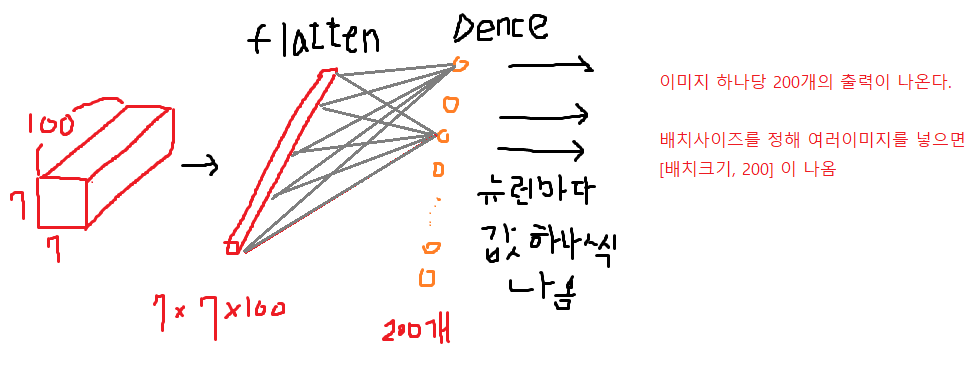


이 밀집층을 7 * 7 크기의 필터 200 개와 valid 패딩을 사용하는 합성곱층으로 바꿔보자  
이 층은 1 * 1 크기의 특성맵 200개를 출력할 것이다.  

이는 밀집층과 마찬가지로 200개의 숫자가 출력된다  

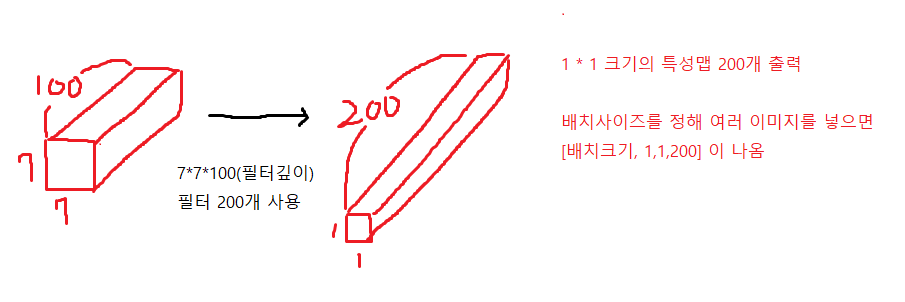


FCN는 합성곱 층만 가지므로 어떤 크기의 이미지에서도 훈련할 수 있다  


FCN은 전체 이미지를 딱 한번 처리   
각 셀(10개의 특성맵에서 같은 위치에 높인 배열의 원소)은 10개의 숫자(5개 클래스 확률, 1개의 존재여부 점수, 4개의 바운딩 박스 좌표)를 담고있다.   
이는 원래 CNN이 NMS방식으로 슬라이딩 하는 것과 같다.

FCN 층은 물체의 위치에 대한 정보도 가지고있다.  
각 출력물은 하나의 클래스를 대표한다.  
대략적인 특성맵들의 크기를 원래 이미지 크기대로 복원 해줄 필요가 있다. -> 디컨볼루션(업샘플링)  


### 시맨틱 분할
픽셀이 속한 객체의 클래스로 분류된다.  
이미지가 CNN을 통과할때 점진적으로 위치정보를 잃는다.    
사전 훈련된 CNN을 FCN으로 변환한다.   
마지막 층이 입력 이미지보다 32배나 작은 특성맵을 출력  

해상도를 32배로 늘리는 업샘플링(디컨볼루션) 필요  




아래쪽 층에서부터 시킵연결을 추가.  
출력 이미지를 업샘츨링하고 아래층의 출력을 더하여 해상도를 두배로 키운다.   
그 후 18배로 늘려서 업샘플링하면 최종적으로 32배의 업샘플링을 달성한다.  
이 방식은 풀링 킁에서 잃은 일부 공간 정보를 복원한다.  
이를 초해상도 라고 부른다.  



### YOLO
https://mickael-k.tistory.com/27  
YOLO(you only look once)는 딱 한번만 본다는 의미이다.(FCN은 아님)  
매우 빨라서 실시간비디오에도 적용이 가능  
YOLOv3는 앞에서 설명한 구조와 비슷하지만 중요한 차이점이 있다.  
* 각 격자셀마다 1개가 아니라 5개의 바운딩 박스를 출력한다. 바운딩 박스 마다 하나의 존재여부 점수가 부여된다.   
20개의 클래스가 있는 데이터셋에서 훈련되었기때문에 격자 셀마다 20개의 클래스 확률을 출력한다.  
따라서 격자 셀 마다 총 45개의 숫자가 출력된다.  
각각 4개의 좌표를 가진 5개의 바운딩박스, 5개의 존재여부, 20개의 클래스 확률  
YOLO초기모델은 바운딩박스당 클래스 확률을 갖지만 YOLOv3에선 셀당 클래스 확률을 갖는다


* 바운딩박스당 나온 클래스들의 확률과 존재여부를 곱하여 7 * 7 * 5 개의 Class-specific confidence score를 갖게된다. NMS(Non Maximum Suppression)을 통해 중복되는 박스를 없앤다.  
Class confidence score(존재확률) 기준으로 박스를 정렬  
그 후 score가 제일 높은 박스를 기준으로 다른 박스를 순서대로 비교하며 NMS를 진행  
최종 박스 그리기








* YOLOv3은 바운딩박스 중심의 절대 좌표를 예측하는 대신 격자 셀에 대한 상대 좌표를 예측한다.  
각 격자셀에 대해 바운딩박스의 중심이 격자 셀 안에 높인 것만을 예측하도록 훈련,(바운딩 박스 자체는 격자 셀 밖으로 넘어갈 수 있다.  

* v3의 경우 앵커박스개념을 도입했다. 
anchor가 없다면 초기학습에서 아무런 정보없이 object의 크기를 예측해야하므로 학습이 오래걸린다.  
v3는 k-평균을 사용해 바운딩 박스의 크기를 정한다. 이를 anchor라 한다.

* 훈련하는 동안 몇 번의 배치마다 랜덤하게 새로운 이미지 차원을 선택(330 * 330 ~ 608 * 608) 까지.  
이를 통해 다른 스케일의 객체를 감지하는 방법을 학습한다.

이미지 -> CNN -> FC -> PT(Prediction Tensor)  
pt = (x,y,w,h,s) * B + class별 예측  
> s = ConfidenceScore(존재여부점수)  
 = (존재확률 * IOU) 
 B = 바운딩박스 개수  

물체가 존재하지 않으면 loss주지않고 그냥 넘어간다 -> 계산속도 높임   
https://mickael-k.tistory.com/27


